In [203]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from typing import Tuple, Iterable
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [3]:
BATCH_SIZE=32

In [171]:
# Let's define the class object of multilayer perceptrons
class DNN(torch.nn.Module):
    def __init__(self, width_vec: list = None):
        super(DNN, self).__init__()
        self.width_vec= width_vec

        modules = []
        if width_vec is None:
            width_vec = [1,256,256,256,1]

        # Network
        for i in range(len(width_vec) - 2):
            modules.append(nn.Linear(width_vec[i],width_vec[i+1]));
            modules.append(nn.ReLU())

        self.net = nn.Sequential(*modules,
                                 nn.Linear(width_vec[-2],width_vec[-1])
                                 )

    def forward(self,x):
        output = self.net(x)
        return  output

In [42]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, attributes, target):
        self.attributes = attributes
        self.target = target

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.attributes)

    def __getitem__(self, index):
        X = torch.tensor(self.attributes[index], dtype=torch.float)
        y = torch.tensor(self.target[index], dtype=torch.float)

        return X, y

In [241]:
df = pd.read_csv('data/Train_Data_Converted&Dropped.csv')
df.head()

,number of rooms,security level of the community,residence space,building space,noise level,waterfront,view,air quality level,aboveground space,basement space,building year,exchange rate,LAT,LNG,timestamp,transaction year,transaction month,transaction day,filled decoration year,total
0,5,2.50,2820,67518,2.0,0,0,3,2820,0,1979,6.784830,47.557085,-122.007748,1398988800,2014,5,2,2014,675000.000105
1,2,1.00,1210,9400,1.0,0,0,2,1210,0,1949,6.243129,47.544034,-122.349874,1398988800,2014,5,2,1949,234999.999988
2,4,2.50,2200,9397,2.0,0,0,3,2200,0,1987,6.010127,47.310617,-122.263291,1398988800,2014,5,2,2000,237227.857125
3,3,1.50,1200,9720,1.0,0,0,4,1200,0,1965,7.560375,47.367737,-122.117029,1398988800,2014,5,2,1965,242499.999935
4,3,1.75,1370,5858,1.0,0,0,3,1370,0,1987,6.543941,47.391319,-122.314971,1398988800,2014,5,2,2000,257949.999962


In [256]:
attributes_scaler = MinMaxScaler()
attributes_data = attributes_scaler.fit_transform(df.drop(['total'], axis=1))
target_scaler = MinMaxScaler()
target_data = target_scaler.fit_transform(df['total'].to_numpy().reshape(-1, 1))
df = pd.concat([
     pd.DataFrame(attributes_data, columns=df.columns[:-1]),
     pd.DataFrame(target_data.squeeze(), columns=['total'])
 ], axis=1)
df.head()

,number of rooms,security level of the community,residence space,building space,noise level,waterfront,view,air quality level,aboveground space,basement space,building year,exchange rate,LAT,LNG,timestamp,transaction year,transaction month,transaction day,filled decoration year,total
0,0.555556,0.31250,0.182304,0.217492,0.4,0.0,0.0,0.50,0.266147,0.0,0.692982,0.392235,0.625836,0.389753,0.0,0.0,0.0,0.033333,1.000000,0.211895
1,0.222222,0.12500,0.059497,0.028185,0.0,0.0,0.0,0.25,0.086860,0.0,0.429825,0.121247,0.601863,0.103344,0.0,0.0,0.0,0.033333,0.424779,0.055199
2,0.444444,0.31250,0.135011,0.028175,0.4,0.0,0.0,0.50,0.197105,0.0,0.763158,0.004686,0.173113,0.175826,0.0,0.0,0.0,0.033333,0.876106,0.055993
3,0.333333,0.18750,0.058734,0.029228,0.0,0.0,0.0,0.75,0.085746,0.0,0.570175,0.780206,0.278033,0.298269,0.0,0.0,0.0,0.033333,0.566372,0.057870
4,0.333333,0.21875,0.071701,0.016648,0.0,0.0,0.0,0.50,0.104677,0.0,0.763158,0.271729,0.321350,0.132563,0.0,0.0,0.0,0.033333,0.876106,0.063373


In [15]:
# generator = torch.random.manual_seed(42)
# train, valid = random_split(df.values, [0.9, 0.1], generator)

In [7]:
# train = DataLoader(train, BATCH_SIZE, shuffle=True, num_workers=2)
# valid = DataLoader(valid, BATCH_SIZE, shuffle=True, num_workers=1)

In [283]:
dataset = Dataset(df.drop(['total', 'transaction year', 'transaction month', 'transaction day', 'timestamp'], axis=1).values, df['total'].values)

In [284]:
dataset[0]

(tensor([0.5556, 0.3125, 0.1823, 0.2175, 0.4000, 0.0000, 0.0000, 0.5000, 0.2661,
         0.0000, 0.6930, 0.3922, 0.6258, 0.3898, 1.0000]),
 tensor(0.2119))

In [285]:
generator = torch.random.manual_seed(42)
train, valid = random_split(dataset, [0.9, 0.1], generator)

In [286]:
train_set = DataLoader(train, BATCH_SIZE, shuffle=True, )
valid_set = DataLoader(valid, BATCH_SIZE, shuffle=True)

In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [261]:
i, (X, y) = next(enumerate(train_set))

In [262]:
X.shape

torch.Size([32, 16])

In [217]:
len(train_set)

108

In [158]:
def to_level(l: Iterable):
    def tier(cost: float):
        if 0 <= cost < 300000: return 1
        elif 300000 <= cost < 500000: return 2
        elif 500000 <= cost < 700000: return 3
        elif 700000 <= cost: return 4
    return np.array([tier(c) for c in l])



In [281]:
def trainer(dataloader: torch.utils.data.DataLoader,
            model: torch.nn.Module,
            optimizer,
            loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    acc = list()
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        tiers = to_level(y)

        # Compute prediction error
        pred = model(X).squeeze()
        # tiers_pred = to_level(pred)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        acc.append((to_level(target_scaler.inverse_transform(pred.detach().numpy().reshape(-1, 1))) == to_level(target_scaler.inverse_transform(y.reshape(-1, 1)).squeeze())).sum()/len(y))
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= num_batches
    print(f"Avg Train loss: {loss:>8f}, Avg accuracy: {np.mean(acc):8f}")
    return train_loss

In [225]:
def evaluator(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print('Avg loss: {:8f}'.format(test_loss))
    return test_loss

In [310]:
model = DNN([15, 256, 256, 256, 1]).to(device)
loss_fn = torch.nn.MSELoss(reduction='sum')
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
EPOCH = 100


In [290]:
model

DNN(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

Avg Train loss: 0.057807, Avg accuracy: 0.473958
Avg loss: 0.119065
Avg Train loss: 0.023794, Avg accuracy: 0.600405
Avg loss: 0.102624
Avg Train loss: 0.014282, Avg accuracy: 0.636285
Avg loss: 0.095797
Avg Train loss: 0.030159, Avg accuracy: 0.639178
Avg loss: 0.097230
Avg Train loss: 0.012062, Avg accuracy: 0.653356
Avg loss: 0.078501
Avg Train loss: 0.018641, Avg accuracy: 0.670718
Avg loss: 0.081285
Avg Train loss: 0.073075, Avg accuracy: 0.667535
Avg loss: 0.083726
Avg Train loss: 0.033353, Avg accuracy: 0.694444
Avg loss: 0.071311
Avg Train loss: 0.043249, Avg accuracy: 0.709780
Avg loss: 0.067755
Avg Train loss: 0.046636, Avg accuracy: 0.717014
Avg loss: 0.075300
Avg Train loss: 0.031484, Avg accuracy: 0.706597
Avg loss: 0.064721
Avg Train loss: 0.046339, Avg accuracy: 0.722801
Avg loss: 0.070894
Avg Train loss: 0.005751, Avg accuracy: 0.713831
Avg loss: 0.067511
Avg Train loss: 0.008017, Avg accuracy: 0.725984
Avg loss: 0.065062
Avg Train loss: 0.008570, Avg accuracy: 0.739294

<AxesSubplot: >

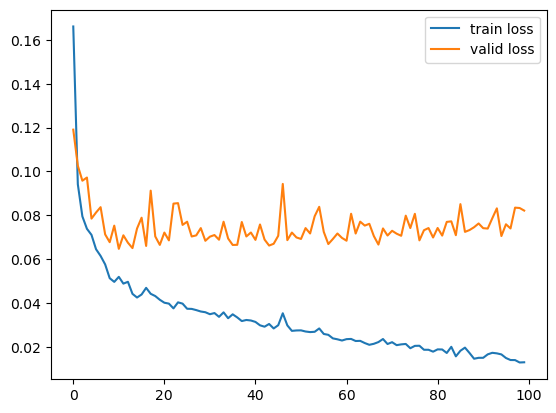

In [311]:
train_loss = list()
valid_loss = list()
for e in range(EPOCH):
    train_loss.append(trainer(train_set, model, optimizer, loss_fn))
    valid_loss.append(evaluator(valid_set, model, loss_fn))

output_df = pd.DataFrame({'train loss': train_loss,
              'valid loss': valid_loss})
output_df.plot()

In [266]:
i, (X, y) = next(enumerate(train_set))
pred = model(X)
pred

tensor([[0.2034],
        [0.1641],
        [0.2331],
        [0.2429],
        [0.0686],
        [0.1286],
        [0.0673],
        [0.1184],
        [0.1261],
        [0.2171],
        [0.0847],
        [0.2048],
        [0.1806],
        [0.2484],
        [0.0849],
        [0.0535],
        [0.2340],
        [0.2383],
        [0.2134],
        [0.1178],
        [0.2232],
        [0.1314],
        [0.0507],
        [0.0809],
        [0.2087],
        [0.0690],
        [0.1071],
        [0.1092],
        [0.1466],
        [0.0731],
        [0.2001],
        [0.1122]], grad_fn=<AddmmBackward0>)

In [267]:
y

tensor([0.2155, 0.1374, 0.2070, 0.3009, 0.0677, 0.1229, 0.0659, 0.0833, 0.1335,
        0.2244, 0.0616, 0.2137, 0.1702, 0.3009, 0.0675, 0.0267, 0.2178, 0.2119,
        0.2099, 0.1131, 0.1774, 0.1051, 0.0427, 0.0759, 0.2030, 0.0641, 0.0570,
        0.0805, 0.1531, 0.0694, 0.1713, 0.1318])

In [274]:
(to_level(target_scaler.inverse_transform(pred.detach().numpy())) == to_level(target_scaler.inverse_transform(y.reshape(-1, 1)).squeeze())).sum()/len(y)

0.65625

In [156]:
(to_level(model(X)) == to_level(y)).sum()/len(y)

0.25